# Planning-only task

Visualization saved as mdp_distinct_paths.png


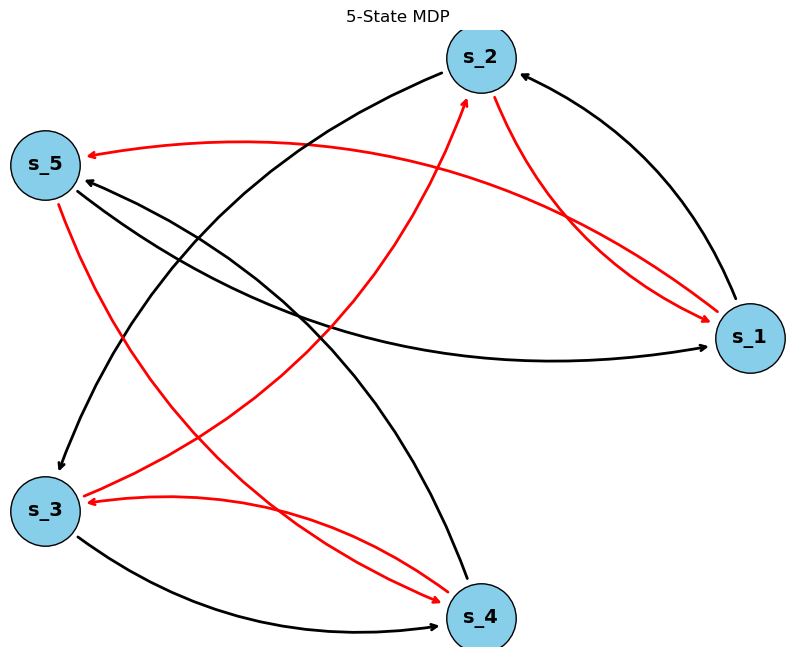

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Define the states and transitions for a 5-state ring MDP
states = ['s_1', 's_2', 's_3', 's_4', 's_5']
transitions = {
    's_1': {'right': 's_2', 'left': 's_5'},
    's_2': {'right': 's_3', 'left': 's_1'},
    's_3': {'right': 's_4', 'left': 's_2'},
    's_4': {'right': 's_5', 'left': 's_3'},
    's_5': {'right': 's_1', 'left': 's_4'}
}

# Visualization using NetworkX
G = nx.MultiDiGraph()
for state, actions in transitions.items():
    for action, next_state in actions.items():
        G.add_edge(state, next_state, action=action)

plt.figure(figsize=(10, 8))
pos = nx.circular_layout(G)

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=2500, node_color='skyblue', edgecolors='black')
nx.draw_networkx_labels(G, pos, font_size=14, font_weight='bold')

ax = plt.gca()
for u, v, data in G.edges(data=True):
    # Using a constant positive radius ensures that the arrow from u->v and v->u 
    # curve in opposite directions relative to the center, thus avoiding overlap.
    rad = 0.25 
    color = "black" if data['action'] == 'right' else "red"
    action_label = data['action']
    
    # Draw arrow
    arrow = ax.annotate("", xy=pos[v], xytext=pos[u],
                arrowprops=dict(arrowstyle="->", color=color, 
                                connectionstyle=f"arc3,rad={rad}", 
                                shrinkA=30, shrinkB=30, lw=2))
    
    # Calculate label position (midpoint of the arc)
    # This is a bit tricky with arc3. We approximate by taking the midpoint and shifting it.
    p1 = np.array(pos[u])
    p2 = np.array(pos[v])
    mid = (p1 + p2) / 2
    # Find the normal to the edge vector
    diff = p2 - p1
    norm = np.array([-diff[1], diff[0]])
    norm = norm / np.linalg.norm(norm)
    # The curvature radius 0.25 shifts the midpoint by roughly 0.125 * distance
    label_pos = mid + norm * 0.15 * np.linalg.norm(diff)
    
    # ax.text(label_pos[0], label_pos[1], action_label, color=color, 
    #         fontsize=10, fontweight='bold', ha='center', va='center',
    #         bbox=dict(facecolor='white', alpha=0.6, edgecolor='none', pad=1))

plt.title("5-State MDP", fontsize=12)
plt.axis('off')
plt.savefig('mdp_distinct_paths.png',dpi=300)

# Displaying paths for queries as requested in the original prompt
# Query 1: s1 to s5
# Path 1 (Short): s1 -> s5 (Action: left) - 1 step
# Path 2 (Long): s1 -> s2 -> s3 -> s4 -> s5 (Action: right, right, right, right) - 4 steps

# Query 2: s1 to s3
# Path 1 (Short): s1 -> s2 -> s3 (Action: right, right) - 2 steps
# Path 2 (Long): s1 -> s5 -> s4 -> s3 (Action: left, left, left) - 3 steps

print("Visualization saved as mdp_distinct_paths.png")

## MDP Structure:

#### States: $s_1, s_2, s_3, s_4, s_5$

#### Actions: Each node has exactly two actions: right (Black) and left (Red).

#### Transitions:

right: $s_1 \to s_2 \to s_3 \to s_4 \to s_5 \to s_1$

left: $s_1 \to s_5 \to s_4 \to s_3 \to s_2 \to s_1$

### Query Examples (Short vs. Long Paths):

#### Query: $s_1$ to $s_5$

Short Path (1 step): $s_1 \xrightarrow{\text{left}} s_5$

Long Path (4 steps): $s_1 \xrightarrow{\text{right}} s_2 \xrightarrow{\text{right}} s_3 \xrightarrow{\text{right}} s_4 \xrightarrow{\text{right}} s_5$

#### Query: $s_1$ to $s_3$

Short Path (2 steps): $s_1 \xrightarrow{\text{right}} s_2 \xrightarrow{\text{right}} s_3$

Long Path (3 steps):  $s_1 \xrightarrow{\text{left}} s_5 \xrightarrow{\text{left}} s_4 \xrightarrow{\text{left}} s_3$

#### Types of Queries (just two examples, there should be more in actual task)

1. Take the shortest path to win 5 dollars between Starting at $s_1$ and ending at $s_3$
   - baseline efficiency: $RT_{t1}$
   - efficiency after learning: $\frac{RT_{t2}}{RT_{t1}}$
3. Take the longest path to win 5 dollars between Starting at $s_1$ and ending at $s_3$
   - capacity at trial 1

In [ ]:
## Task Logic

1. Random 1-step learning of structure (80 Trials)
2 Query knowledge of 1-step learning
3. Ask questions
4. Quey again knowledge of 1-step learning

# MF vs MB strategy selection task

1. Decision tree (random 1-step learning)
2. Query 1-step knowledge.
3. Develop habit through pursuing reward in one location
4. Have transition revaluation where a longer path takes one to MF goal
5. Have the same path changed in (4) change again, but now theyve learned that this path does not affect MF policy.
6. Have transition revaluation along new key action transition where new path leads to better goal

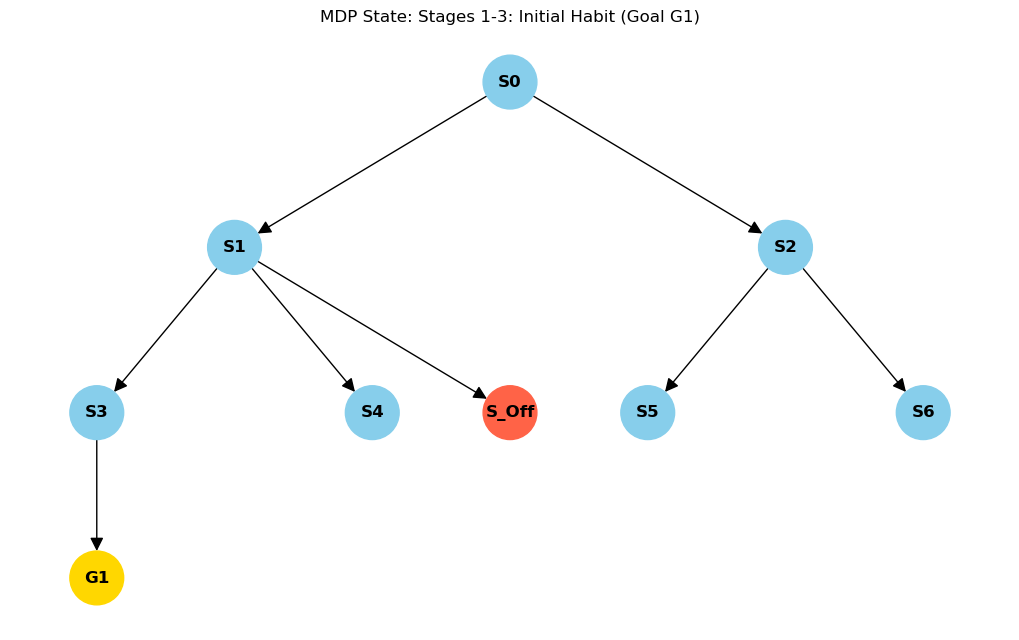

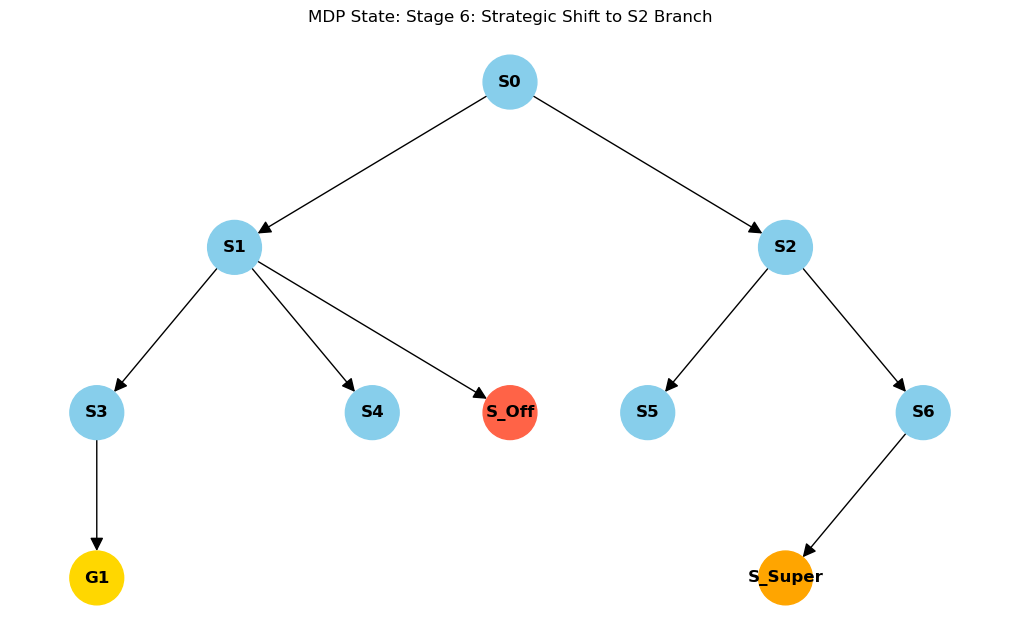

In [5]:
import networkx as nx
import matplotlib.pyplot as plt

def visualize_complex_mdp(stage_name, edges, reward_nodes, super_reward=None):
    G = nx.DiGraph()
    G.add_edges_from(edges)
    
    # Hierarchy Layout
    pos = {
        'S0': (0, 3),
        'S1': (-2, 2), 'S2': (2, 2),
        'S3': (-3, 1), 'S4': (-1, 1), 'S_Off': (0, 1), # S_Off is the 3rd action from S1
        'S5': (1, 1), 'S6': (3, 1),
        'G1': (-3, 0), 'G2': (-1, 0), 'G3': (1, 0), 'G4': (3, 0),
        'S_Super': (2, 0) # The high-value goal for Stage 6
    }
    
    plt.figure(figsize=(10, 6))
    node_colors = []
    for node in G.nodes():
        if node == 'S_Super': node_colors.append('orange')
        elif node in reward_nodes: node_colors.append('gold')
        elif node == 'S_Off': node_colors.append('tomato')
        else: node_colors.append('skyblue')

    nx.draw(G, pos, with_labels=True, node_size=1500, node_color=node_colors, 
            arrowsize=20, font_weight='bold')
    
    plt.title(f"MDP State: {stage_name}")
    plt.show()

# --- Stage Definitions ---

# 1-3: Base Tree with 3rd action at S1
edges_base = [
    ('S0', 'S1'), ('S0', 'S2'),
    ('S1', 'S3'), ('S1', 'S4'), ('S1', 'S_Off'), # Three actions!
    ('S2', 'S5'), ('S2', 'S6'),
    ('S3', 'G1')
]
visualize_complex_mdp("Stages 1-3: Initial Habit (Goal G1)", edges_base, ['G1'])

# 6: Shift to S2 side for Super Reward
edges_final = edges_base + [('S6', 'S_Super')]
visualize_complex_mdp("Stage 6: Strategic Shift to S2 Branch", edges_final, ['G1'], 'S_Super')

### Decision Tree Learning (1-Step & Habit)

Initially, the agent performs model-based exploration to populate the transition matrix $T$ and reward vector $R$.

### Query 1-Step Knowledge

The agent evaluates the state-action value $Q$ for the root node $S_0$ using the Bellman equation:$$Q(S_0, a_1) = \mathbb{E} [R_{t+1} + \gamma \max_{a'} Q(S_1, a')]$$Since $S_1$ leads to $G_1$ (Reward 10), whereas $S_2$ leads to $G_{Super}$ (Reward 1), the agent chooses $a_1$. Over many trials, this is cached as a Model-Free (MF) habit:$$Q_{MF}(S_0, a_1) \leftarrow 10.0$$
 
### Transition Revaluation (Strategy Selection)

Stage 4 & 5: Redundant Path ChangesIn these stages, we introduce a third action at $S_1$ leading to $S_{Off}$. 

Even if $S_{Off}$ is updated to lead to a reward ($G_2 = 5$), the agent compares this to the cached habit.

### The Strategy Selection Query

The agent assesses if the cost of replanning (Model-Based) is justified by the change in the environment:$$\text{If } \max [Q_{MB}(S_1, a_{off})] < Q_{MF}(S_1, a_{habit}) \implies \text{Remain Model-Free}$$Because $10 > 5$, the agent realizes this transition revaluation does not impact the optimality of the current policy. It maintains the $S_0 \rightarrow S_1$ habit.3. 

### Policy Shift (Goal Revaluation)

Stage 6: The Super RewardA transition revaluation occurs on the "ignored" side of the tree ($S_2$). $G_{Super}$ is updated from $1$ to $50$.

MB-RL Planning Query

The Model-Based system detects a massive Reward Prediction Error (RPE) or a "revaluation signal." It triggers a full tree search:

$Q_{MB}(S_0, a_1) = 10$ 

$Q_{MB}(S_0, a_2) = 50$

Optimal Decision:$$\pi(S_0) = \arg\max_{a} \{ Q_{MB}(S_0, a) \} = a_2$$The agent successfully inhibits the $a_1$ habit to switch to the $a_2$ branch, demonstrating the flexibility of Model-Based RL when the environment's changes finally cross the threshold of optimality.